#### **Importo las Librerías Necesarias**

In [55]:

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import os
import pyarrow.parquet as pq   
import ast

#### **Cargo los archivos Parquet**

Cargaré los datos de películas (movies_df), créditos (credits_df), equipo (crew_df), y elenco (cast_df) desde sus respectivas rutas. La idea es empezar revisando cómo están estructurados estos datos.
La función info() proporciona una visión general, mostrando cuántas entradas hay y si existen valores nulos.
A través de head(), observo las primeras filas para comprender el contenido de cada DataFrame y las variables que trabajaré.

In [56]:
# Definir las rutas de los archivos
ruta_movies = 'Datasets/movies_df.parquet'
ruta_credits = 'Datasets/credits_df.parquet'
ruta_crew = 'Datasets/crew_df.parquet'
ruta_cast = 'Datasets/cast_df.parquet'

# Cargar los archivos Parquet en DataFrames
movies_df = pd.read_parquet(ruta_movies)
credits_df = pd.read_parquet(ruta_credits)
crew_df = pd.read_parquet(ruta_crew)
cast_df = pd.read_parquet(ruta_cast)

In [57]:
print(movies_df.head())

     budget     id original_language  \
0  30000000    862                en   
1  65000000   8844                en   
2         0  15602                en   
3  16000000  31357                en   
4         0  11862                en   

                                            overview  popularity release_date  \
0  Led by Woody, Andy's toys live happily in his ...   21.946943   1995-10-30   
1  When siblings Judy and Peter discover an encha...   17.015539   1995-12-15   
2  A family wedding reignites the ancient feud be...   11.712900   1995-12-22   
3  Cheated on, mistreated and stepped on, the wom...    3.859495   1995-12-22   
4  Just when George Banks has recovered from his ...    8.387519   1995-02-10   

       revenue  runtime    status                        title  vote_average  \
0  373554033.0     81.0  Released                    Toy Story           7.7   
1  262797249.0    104.0  Released                      Jumanji           6.9   
2          0.0    101.0  Release

In [58]:
print(movies_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44344 entries, 0 to 44343
Data columns (total 18 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   budget                    44344 non-null  int64   
 1   id                        44344 non-null  int64   
 2   original_language         44344 non-null  category
 3   overview                  44344 non-null  object  
 4   popularity                44344 non-null  float64 
 5   release_date              44344 non-null  object  
 6   revenue                   44344 non-null  float64 
 7   runtime                   44344 non-null  float64 
 8   status                    44344 non-null  category
 9   title                     44344 non-null  object  
 10  vote_average              44344 non-null  float64 
 11  vote_count                44344 non-null  float64 
 12  production_company_names  44344 non-null  category
 13  genre_names               44344 non-null  cate

In [59]:
print(credits_df.head())

                                                cast  \
0  [{'cast_id': 14, 'character': 'Woody (voice)',...   
1  [{'cast_id': 1, 'character': 'Alan Parrish', '...   
2  [{'cast_id': 2, 'character': 'Max Goldman', 'c...   
3  [{'cast_id': 1, 'character': "Savannah 'Vannah...   
4  [{'cast_id': 1, 'character': 'George Banks', '...   

                                                crew     id  
0  [{'credit_id': '52fe4284c3a36847f8024f49', 'de...    862  
1  [{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...   8844  
2  [{'credit_id': '52fe466a9251416c75077a89', 'de...  15602  
3  [{'credit_id': '52fe44779251416c91011acb', 'de...  31357  
4  [{'credit_id': '52fe44959251416c75039ed7', 'de...  11862  


In [60]:
print(crew_df.head())

    id       crew_name    crew_job department  gender
0  862   John Lasseter    Director  Directing       2
1  862     Joss Whedon  Screenplay    Writing       2
2  862  Andrew Stanton  Screenplay    Writing       2
3  862      Joel Cohen  Screenplay    Writing       2
4  862    Alec Sokolow  Screenplay    Writing       0


In [61]:
print(cast_df.head())

    id      cast_name                character  gender
0  862      Tom Hanks            Woody (voice)       2
1  862      Tim Allen   Buzz Lightyear (voice)       2
2  862    Don Rickles  Mr. Potato Head (voice)       2
3  862     Jim Varney       Slinky Dog (voice)       2
4  862  Wallace Shawn              Rex (voice)       2


#### **Descripción de Variables Importantes**

Para asegurarme de que comprendo los atributos críticos, me he centrado en examinar las columnas `budget`, `revenue`, `popularity`, `runtime`, y `release_date`. Esto me permitirá analizar mejor cómo estas variables podrían afectar las recomendaciones.

In [62]:
# Describir las columnas numéricas y sus estadísticas
print(movies_df[['budget', 'revenue', 'popularity', 'runtime']].describe())

             budget       revenue    popularity      runtime
count  4.434400e+04  4.434400e+04  44344.000000  44344.00000
mean   4.326717e+06  1.148957e+07      2.980884     95.06188
std    1.762906e+07  6.511207e+07      6.066515     37.49327
min    0.000000e+00  0.000000e+00      0.000000      0.00000
25%    0.000000e+00  0.000000e+00      0.407776     85.00000
50%    0.000000e+00  0.000000e+00      1.165846     95.00000
75%    0.000000e+00  0.000000e+00      3.824751    107.00000
max    3.800000e+08  2.787965e+09    547.488298   1256.00000


Veo que tanto el presupuesto (`budget`) como los ingresos (`revenue`) tienen una alta variabilidad y muchos valores en cero, lo que me hace pensar en datos faltantes o inconsistentes. La popularidad tiene un rango muy amplio, lo que sugiere la presencia de outliers significativos. Finalmente, el tiempo de duración (`runtime`) parece más consistente, pero algunos valores extremos podrían necesitar revisión.

#### **Análisis de Valores Nulos**

Uno de los pasos más críticos es verificar si hay valores nulos en las columnas principales, ya que esto puede afectar la calidad del modelo de recomendación.

In [63]:
# Comprobar valores nulos
print(movies_df.isnull().sum())

budget                      0
id                          0
original_language           0
overview                    0
popularity                  0
release_date                0
revenue                     0
runtime                     0
status                      0
title                       0
vote_average                0
vote_count                  0
production_company_names    0
genre_names                 0
country_names               0
language_names              0
release_year                0
return                      0
dtype: int64


In [64]:
# Detectar valores nulos en el DataFrame
nulos_detalle = movies_df.isna().sum()
nulos_detalle

budget                      0
id                          0
original_language           0
overview                    0
popularity                  0
release_date                0
revenue                     0
runtime                     0
status                      0
title                       0
vote_average                0
vote_count                  0
production_company_names    0
genre_names                 0
country_names               0
language_names              0
release_year                0
return                      0
dtype: int64

In [65]:
# Contar los ceros en las columnas 'budget' y 'revenue'
ceros_budget = (movies_df['budget'] == 0).sum()
ceros_revenue = (movies_df['revenue'] == 0).sum()

print("Ceros en 'budget':", ceros_budget)
print("Ceros en 'revenue':", ceros_revenue)

Ceros en 'budget': 35509
Ceros en 'revenue': 36963



Durante el análisis del dataset movies_df, utilicé los métodos isnull().sum() e isna().sum() para detectar valores nulos, y aunque inicialmente no aparecieron problemas evidentes, al contar los ceros en las columnas budget y revenue, descubrí un número significativo de registros con ceros, lo que indica datos faltantes. En lugar de eliminar estas filas, decidí que dejaré los registros y buscaré una alternativa para manejar los ceros, ya que esto podría impactar en la calidad del dataset y la efectividad del modelo de recomendación.

He generado gráficos para analizar la distribución de ingresos, la relación entre presupuesto y ganancias, y la popularidad frente a calificaciones. Estas visualizaciones me ayudarán a identificar patrones relevantes que optimicen mi modelo de recomendación de películas.

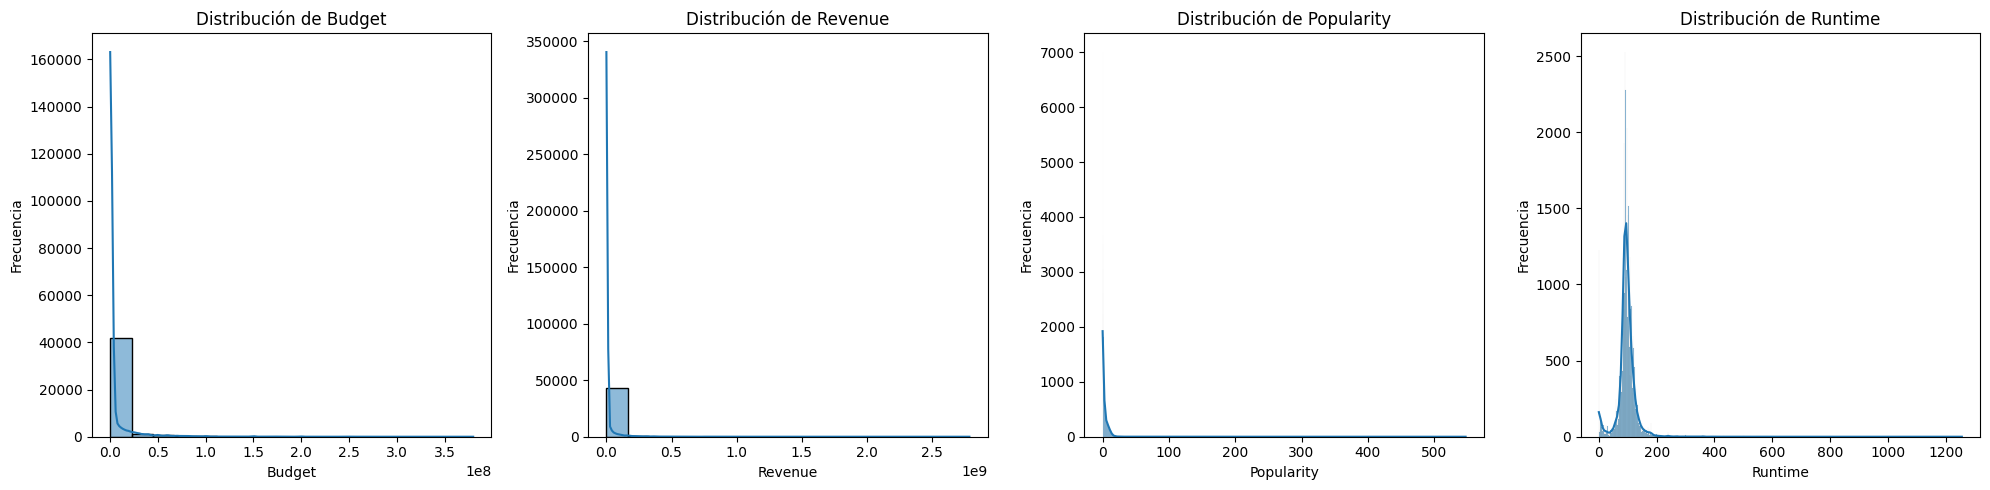

In [66]:
# Configuramos el tamaño de la figura y la cuadrícula de 1 fila y 4 columnas
fig, axes = plt.subplots(1, 4, figsize=(20, 5))

# Gráfico 1: Distribución de budget
sns.histplot(movies_df['budget'], ax=axes[0], kde=True)
axes[0].set_title('Distribución de Budget')
axes[0].set_xlabel('Budget')
axes[0].set_ylabel('Frecuencia')

# Gráfico 2: Distribución de revenue
sns.histplot(movies_df['revenue'], ax=axes[1], kde=True)
axes[1].set_title('Distribución de Revenue')
axes[1].set_xlabel('Revenue')
axes[1].set_ylabel('Frecuencia')

# Gráfico 3: Distribución de popularity
sns.histplot(movies_df['popularity'], ax=axes[2], kde=True)
axes[2].set_title('Distribución de Popularity')
axes[2].set_xlabel('Popularity')
axes[2].set_ylabel('Frecuencia')

# Gráfico 4: Distribución de runtime
sns.histplot(movies_df['runtime'], ax=axes[3], kde=True)
axes[3].set_title('Distribución de Runtime')
axes[3].set_xlabel('Runtime')
axes[3].set_ylabel('Frecuencia')

# Ajustar el layout
plt.tight_layout()
plt.show()


En los gráficos de distribución observé que las variables **Budget**, **Revenue**, **Popularity** y **Runtime** presentan sesgos hacia la izquierda, con valores altos poco frecuentes. Esto me servirá para identificar y manejar outliers.


Para tratar los outliers en movies_df, utilizaré el rango intercuartílico (IQR) para identificar valores extremos en las columnas budget, revenue, popularity y runtime. Dependiendo de los resultados, consideraré eliminarlos o aplicar transformaciones.

In [67]:
# Función para eliminar outliers usando el método IQR
def eliminar_outliers(df, columna):
    Q1 = df[columna].quantile(0.25)
    Q3 = df[columna].quantile(0.75)
    IQR = Q3 - Q1
    limite_inferior = Q1 - 1.5 * IQR
    limite_superior = Q3 + 1.5 * IQR
    return df[(df[columna] >= limite_inferior) & (df[columna] <= limite_superior)]

# Aplicar la función a las columnas de interés
columns_to_check = ['budget', 'revenue', 'popularity', 'runtime']
for column in columns_to_check:
    movies_df = eliminar_outliers(movies_df, column)

# Ver la cantidad de filas eliminadas
print("Número de filas restantes:", movies_df.shape[0])


Número de filas restantes: 25919


Después de eliminar los outliers del dataset `movies_df`, he reducido el número de filas a **25,919**. Este proceso es crucial, ya que la eliminación de outliers puede mejorar la calidad de los datos y, por ende, el rendimiento del modelo de recomendación. Al contar con un dataset más limpio y representativo, espero que el modelo pueda aprender patrones más relevantes y ofrecer recomendaciones más precisas.

#### **Distribución de Géneros y Análisis de Popularidad**

He decidido visualizar la distribución de los géneros de las películas y analizar cómo se relaciona la popularidad con el año de lanzamiento.

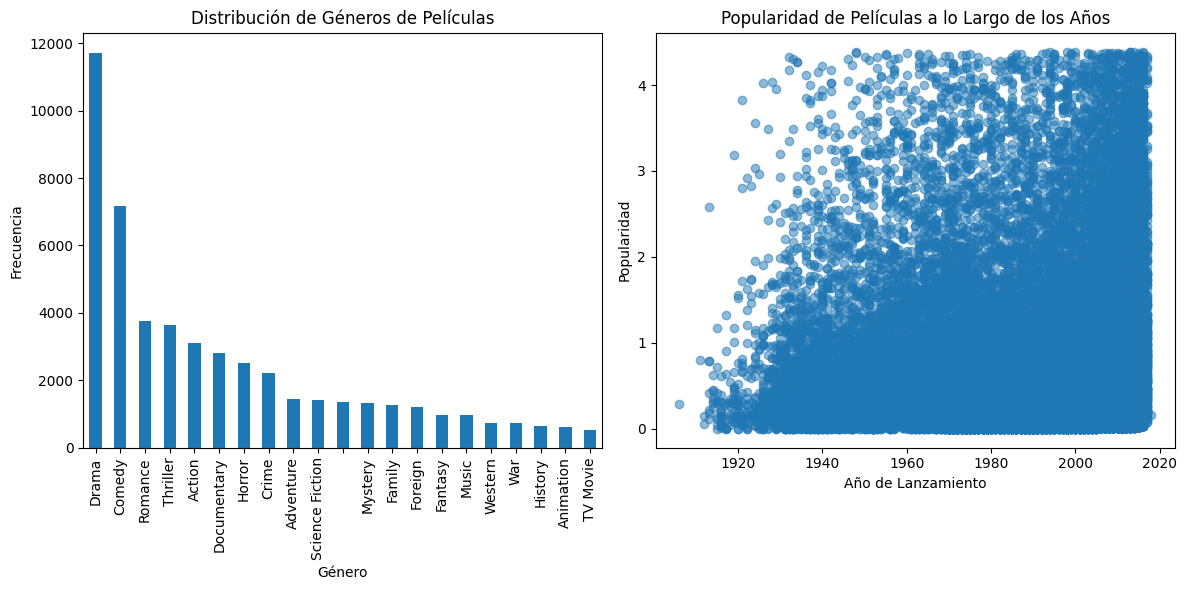

In [68]:
# Análisis de los géneros
import matplotlib.pyplot as plt

# Configuración de la figura para dos gráficos
plt.figure(figsize=(12, 6))

# Gráfico de distribución de géneros
plt.subplot(1, 2, 1)
generos = movies_df['genre_names'].str.split(', ').explode()
generos.value_counts().plot(kind='bar')
plt.title('Distribución de Géneros de Películas')
plt.xlabel('Género')
plt.ylabel('Frecuencia')

# Gráfico de relación entre popularidad y año de lanzamiento
plt.subplot(1, 2, 2)
plt.scatter(movies_df['release_year'], movies_df['popularity'], alpha=0.5)
plt.title('Popularidad de Películas a lo Largo de los Años')
plt.xlabel('Año de Lanzamiento')
plt.ylabel('Popularidad')

plt.tight_layout()
plt.show()


Observo que el género Drama es el más frecuente, seguido de Comedy y Romance, mientras que géneros como Animation son menos comunes. Además, la popularidad de las películas tiende a aumentar en las producciones más recientes. Para mejorar el modelo, podríamos enfocarnos en equilibrar los géneros menos representados y considerar la popularidad por año como una variable de ajuste en las recomendaciones.

#### **Incorporar Información de Actores y Directores**

Agregar características adicionales, como información sobre actores y directores, es una excelente forma de enriquecer tu modelo de recomendaciones y hacer que sea más preciso y personalizado. 

#### **Limpiar Datasets**

In [69]:
print(cast_df.columns)
print(crew_df.columns)


Index(['id', 'cast_name', 'character', 'gender'], dtype='object')
Index(['id', 'crew_name', 'crew_job', 'department', 'gender'], dtype='object')


In [70]:
# Eliminar valores nulos
# Primero, elimino filas con valores nulos en las columnas 'cast_name' y 'character' del DataFrame cast_df.
cast_df.dropna(subset=['cast_name', 'character'], inplace=True)

# Hago lo mismo en crew_df, eliminando filas con nulos en 'crew_name' y 'crew_job'.
crew_df.dropna(subset=['crew_name', 'crew_job'], inplace=True)

# Comprobación de duplicados
# A continuación, elimino duplicados de ambos DataFrames para asegurarme de que cada fila sea única.
cast_df.drop_duplicates(inplace=True)
crew_df.drop_duplicates(inplace=True)

# Normalización de nombres de columnas
# Finalmente, normalizo los nombres de las columnas convirtiéndolos a minúsculas para que sean consistentes.
cast_df.columns = [col.lower() for col in cast_df.columns]
crew_df.columns = [col.lower() for col in crew_df.columns]

# Guardar los DataFrames limpios
# Al final, guardo los DataFrames limpios en archivos CSV para su uso posterior.
cast_df.to_parquet('Datasets/cast_df_cleaned.parquet', index=False)
crew_df.to_parquet('Datasets/crew_df_cleaned.parquet', index=False)

### Análisis de Géneros y Popularidad

**Géneros de Películas**

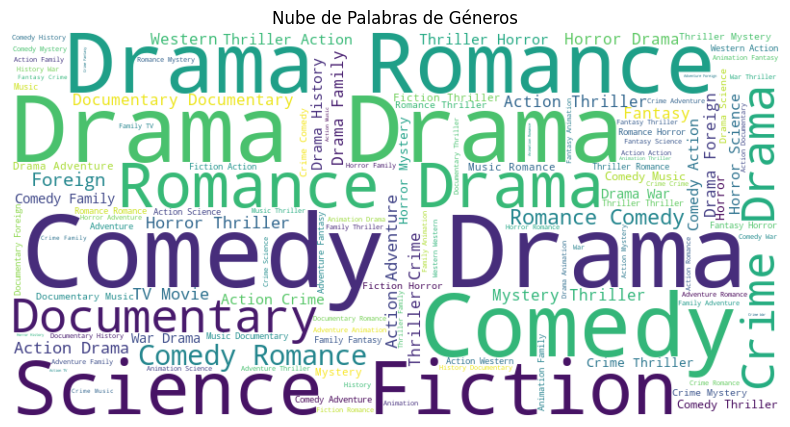

In [71]:
all_genres = " ".join(movies_df['genre_names'].dropna().str.replace(',', ' '))

# Crear la nube de palabras
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_genres)

# Mostrar la nube de palabras
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Ocultar los ejes
plt.title('Nube de Palabras de Géneros')
plt.show()


Los géneros más destacados en la nube de palabras son Science Fiction, Drama, Comedy, Romance,lo que muestra su alta frecuencia en el dataset. Para el modelo de recomendación, estos géneros dominantes podrían reflejar las preferencias generales de los usuarios. Sin embargo, al estar concatenados, existe el riesgo de confundir combinaciones como "Science Fiction" y "Drama", lo que podría afectar la precisión del modelo.

#### **Distribución de los puntajes promedio**

Voy a examinar la distribución de los puntajes promedio de las películas utilizando un histograma. Esta visualización me ayudará a entender cómo se distribuyen las calificaciones en el dataset, lo cual es relevante para mi modelo de recomendación. Identificar películas con altos puntajes puede ayudar a priorizarlas en las recomendaciones.

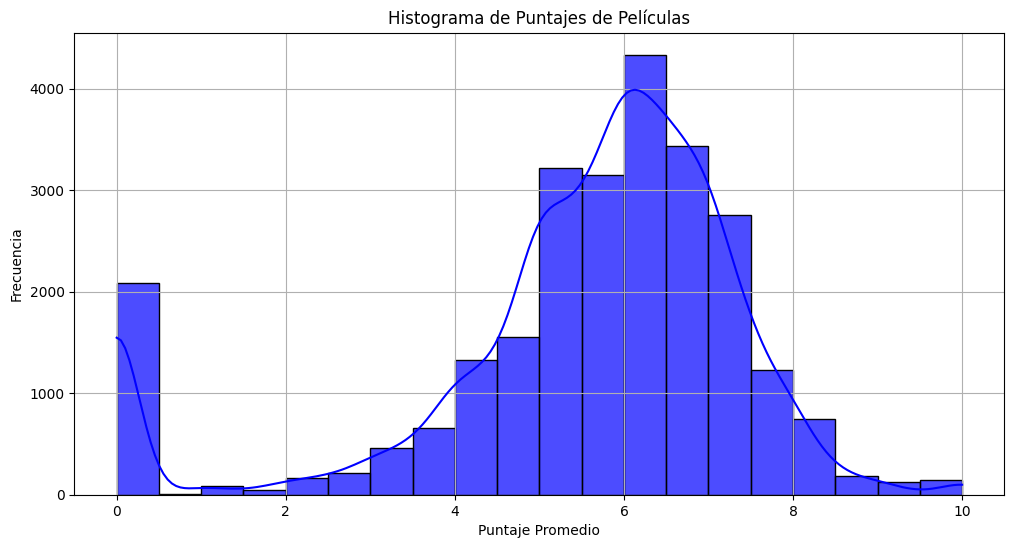

In [72]:
# Histograma de puntajes
plt.figure(figsize=(12, 6))
sns.histplot(movies_df['vote_average'], bins=20, kde=True, color='blue', alpha=0.7)
plt.title('Histograma de Puntajes de Películas')
plt.xlabel('Puntaje Promedio')
plt.ylabel('Frecuencia')
plt.grid(True)
plt.show()

La distribución de puntajes promedio presenta una forma aproximadamente normal con una ligera asimetría a la izquierda. La mayoría de las películas se agrupan entre puntajes de 5 a 7, indicando una tendencia hacia calificaciones medias. Sin embargo, hay outliers en el rango bajo (puntajes cercanos a 0), que podrían representar películas con malas críticas o errores en los datos. Dado que estos puntajes pueden reflejar opiniones reales, no considero necesario eliminarlos, pero los tendré en cuenta en el análisis de recomendaciones para asegurar que no afecten desproporcionadamente al sistema.

**Participacion de Actores y Directores**

C:\Users\NOTEBOOK\AppData\Local\Temp\ipykernel_8984\2607036901.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='count', y='actor', data=actors_count.head(10), palette='viridis', ax=axes[0])
C:\Users\NOTEBOOK\AppData\Local\Temp\ipykernel_8984\2607036901.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='count', y='director', data=directors_count.head(10), palette='viridis', ax=axes[1])


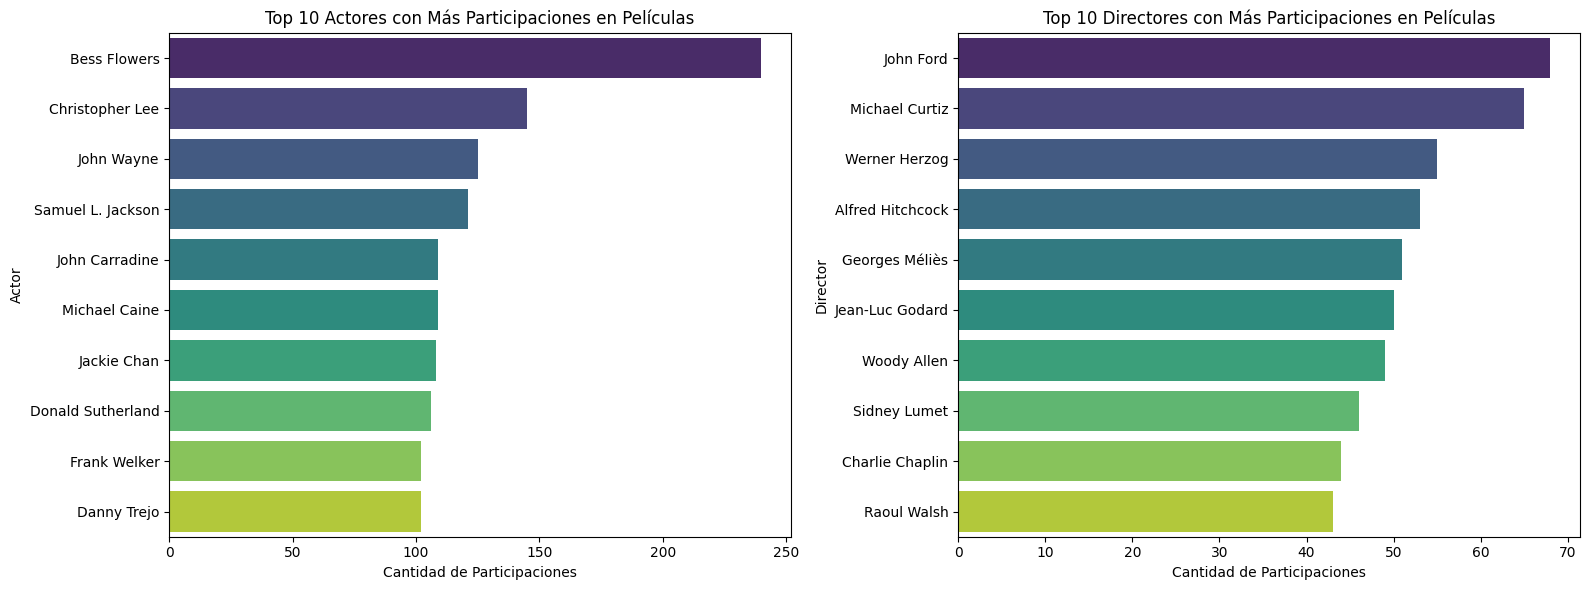

In [73]:
# Contar las participaciones de actores
actors_count = cast_df['cast_name'].value_counts().reset_index()
actors_count.columns = ['actor', 'count']

# Contar las participaciones de directores
directors_count = crew_df[crew_df['crew_job'] == 'Director']['crew_name'].value_counts().reset_index()
directors_count.columns = ['director', 'count']

# Crear una figura con 2 subgráficas en la misma fila
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Gráfico de los 10 actores con más participaciones
sns.barplot(x='count', y='actor', data=actors_count.head(10), palette='viridis', ax=axes[0])
axes[0].set_title('Top 10 Actores con Más Participaciones en Películas')
axes[0].set_xlabel('Cantidad de Participaciones')
axes[0].set_ylabel('Actor')

# Gráfico de los 10 directores con más participaciones
sns.barplot(x='count', y='director', data=directors_count.head(10), palette='viridis', ax=axes[1])
axes[1].set_title('Top 10 Directores con Más Participaciones en Películas')
axes[1].set_xlabel('Cantidad de Participaciones')
axes[1].set_ylabel('Director')

# Ajustar el layout
plt.tight_layout()
plt.show()

Observo que los actores y directores con más participaciones no son conocidos, probablemente debido a la antigüedad y origen de las películas. Planeo ajustar el dataset para enfocarme solo en producciones de Estados Unidos y desde 1975 en adelante. Esto permitirá que el sistema de recomendaciones sugiera contenido más relevante y familiar para los usuarios actuales, aumentando la probabilidad de interacción y satisfacción con las recomendaciones generadas.

In [74]:
# Filtrar películas de Estados Unidos (country_names) y producidas a partir de 1975 (release_year)
filtered_movies_df = movies_df[
    (movies_df['country_names'].str.contains('United States of America')) & 
    (movies_df['release_year'] >= 1970)
]

# Mostrar el número total de películas  de Estados Unidos y producidas a partir de 1975
print(f"Total de películas  de Estados Unidos y producidas a partir de 1970: {len(filtered_movies_df)}")

Total de películas  de Estados Unidos y producidas a partir de 1970: 6712


In [75]:
# Mostrar el número total de actores únicos antes de la filtración
total_actores_antes = cast_df['cast_name'].nunique()
print(f"Total de actores únicos antes de la filtración: {total_actores_antes}")

# Contar las veces que cada actor aparece y ordenar en orden descendente
actors_top_voted = cast_df['cast_name'].value_counts().head(8000).index

# Filtrar el DataFrame para que solo contenga los 8000 actores más frecuentes
cast_df = cast_df[cast_df['cast_name'].isin(actors_top_voted)].copy()

# Mostrar el número de actores únicos que quedan después de la filtración
total_actores_despues = cast_df['cast_name'].nunique()
print(f"Total de actores únicos después de la filtración: {total_actores_despues}")

Total de actores únicos antes de la filtración: 175935
Total de actores únicos después de la filtración: 8000


#### **Matriz de correlación**

En mi matriz de correlación incluiré las siguientes variables: budget, revenue, vote_average, popularity y runtime. Estas variables me ayudarán a identificar las relaciones y patrones relevantes para el análisis y el sistema de recomendación.

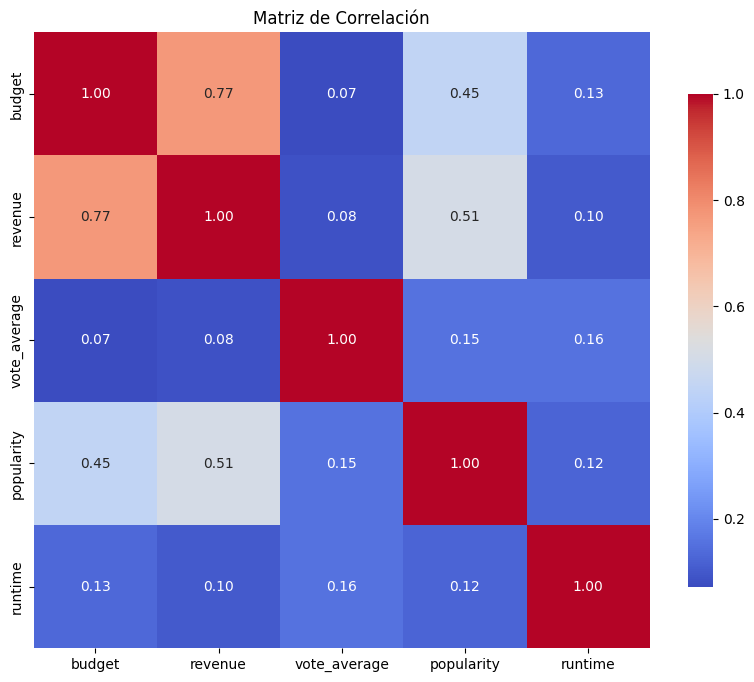

In [76]:
# Definir la ruta de tu dataset
ruta_movies = 'Datasets/movies_df.parquet'  # Reemplaza esto con la ruta correcta si es necesario

# Cargar el dataset
movies_df = pd.read_parquet(ruta_movies)  # Asegúrate de que el archivo esté en formato Parquet

# Seleccionar las variables para la matriz de correlación
variables = ['budget', 'revenue', 'vote_average', 'popularity', 'runtime']

# Calcular la matriz de correlación
correlation_matrix = movies_df[variables].corr()

# Configurar el tamaño del gráfico
plt.figure(figsize=(10, 8))

# Crear el mapa de calor
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', square=True, cbar_kws={"shrink": .8})

# Títulos y etiquetas
plt.title('Matriz de Correlación')
plt.show()


En esta matriz de correlación, noto que existe una fuerte relación entre el presupuesto y los ingresos de las películas (0.77), lo cual sugiere que las producciones con mayor presupuesto tienden a generar más ingresos. También observo que la popularidad muestra una correlación moderada tanto con los ingresos (0.51) como con el presupuesto (0.45), indicando que estas variables podrían estar vinculadas a la atención que recibe una película. Las demás correlaciones son bajas, lo que sugiere que no tienen una relación significativa entre sí en este contexto.

#### **Análisis Univariable de Popularity y Runtime**

Estoy explorando de forma univariable las distribuciones de popularity y runtime. Utilizo histogramas para visualizar la frecuencia de los valores de estas variables. Esto me permite observar si hay sesgos o posibles valores atípicos que puedan influir en el modelo de recomendación.

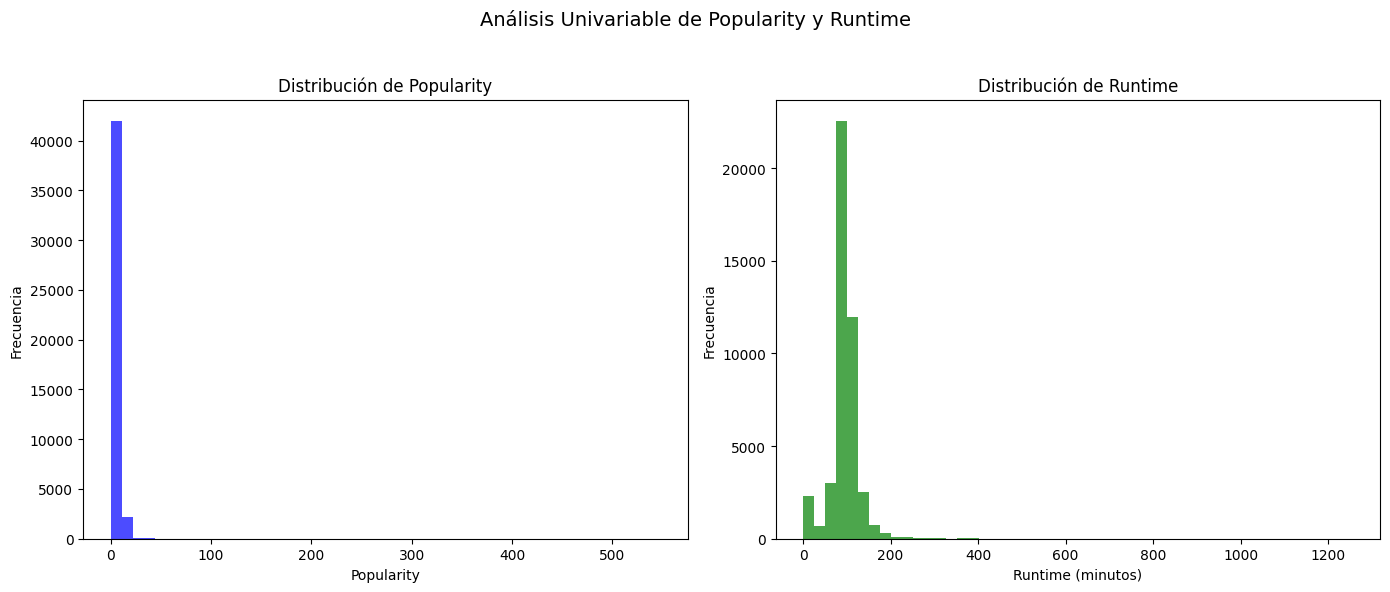

In [77]:
# Crear una figura con dos gráficos en una fila
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle('Análisis Univariable de Popularity y Runtime', fontsize=14)

# Histograma de la variable 'popularity'
axes[0].hist(movies_df['popularity'], bins=50, color='blue', alpha=0.7)
axes[0].set_title('Distribución de Popularity')
axes[0].set_xlabel('Popularity')
axes[0].set_ylabel('Frecuencia')

# Histograma de la variable 'runtime'
axes[1].hist(movies_df['runtime'].dropna(), bins=50, color='green', alpha=0.7)
axes[1].set_title('Distribución de Runtime')
axes[1].set_xlabel('Runtime (minutos)')
axes[1].set_ylabel('Frecuencia')

# Mostrar los gráficos
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Ajustar el diseño para que no se solapen con el título
plt.show()


Los histogramas muestran una distribución muy sesgada en ambas variables: popularity parece tener un gran sesgo hacia la izquierda, con la mayoría de los valores concentrados en un rango muy pequeño, mientras que runtime muestra un patrón más centralizado, pero con algunos valores extremos. Esto sugiere que podría ser útil realizar un tratamiento adicional de valores atípicos o una transformación para normalizar estas variables antes del modelado.

#### **Analizar los valores atípicos en las variables popularity y runtime**

Voy a analizar los valores atípicos en las variables popularity y runtime utilizando boxplots. Esto me ayudará a visualizar de manera clara los outliers presentes en cada distribución. Dependiendo de los resultados, puedo decidir aplicar transformaciones logarítmicas o técnicas de recorte para minimizar el impacto de estos valores extremos.

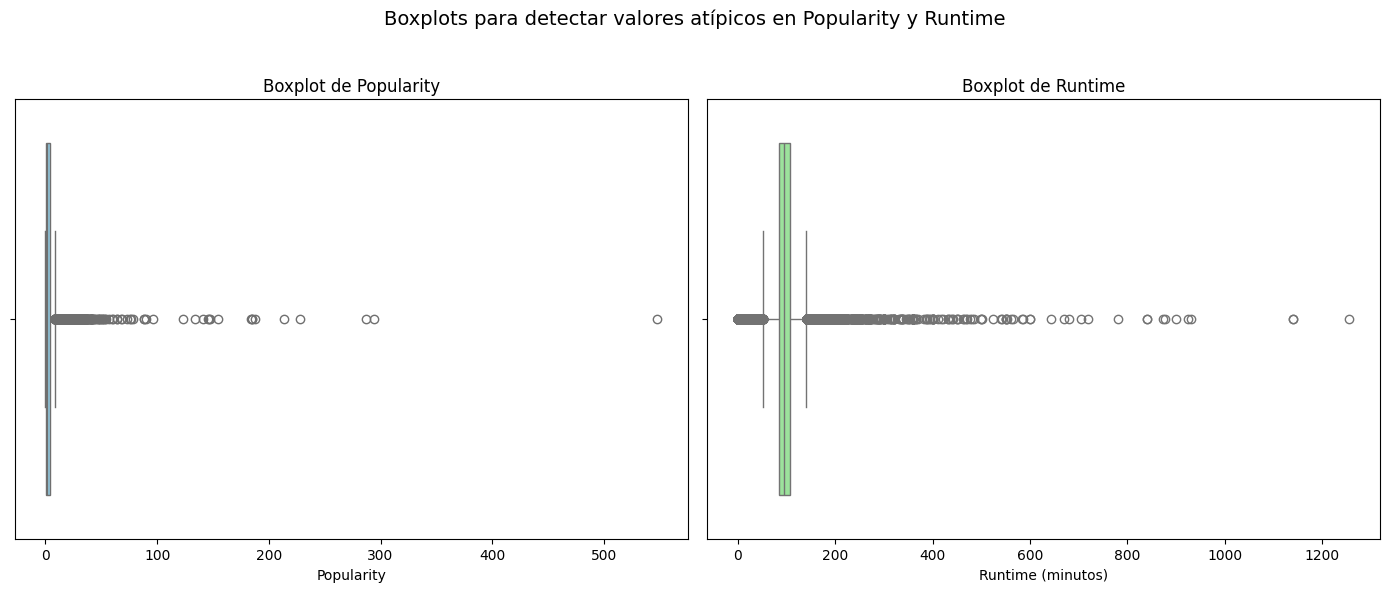

In [78]:
# Configuración de los gráficos
plt.figure(figsize=(14, 6))
plt.suptitle('Boxplots para detectar valores atípicos en Popularity y Runtime', fontsize=14)

# Boxplot para Popularity
plt.subplot(1, 2, 1)
sns.boxplot(data=movies_df, x='popularity', color='skyblue')
plt.title('Boxplot de Popularity')
plt.xlabel('Popularity')

# Boxplot para Runtime
plt.subplot(1, 2, 2)
sns.boxplot(data=movies_df, x='runtime', color='lightgreen')
plt.title('Boxplot de Runtime')
plt.xlabel('Runtime (minutos)')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


En el gráfico de popularity, se observan películas extremadamente populares que se destacan como outliers, mientras que en runtime se pueden ver algunas películas inusualmente cortas o largas. Evaluaré si vale la pena transformar o recortar estos valores según su impacto en el modelo de recomendación.

#### **Eliminar outliers basados en el rango intercuartílico (IQR)**

In [79]:
# Definir una función para eliminar outliers basados en el rango intercuartílico (IQR)
def eliminar_outliers(df, columna):
    Q1 = df[columna].quantile(0.25)
    Q3 = df[columna].quantile(0.75)
    IQR = Q3 - Q1
    # Definir los límites inferior y superior
    limite_inferior = Q1 - 1.5 * IQR
    limite_superior = Q3 + 1.5 * IQR
    # Filtrar el DataFrame para mantener solo los valores dentro de los límites
    return df[(df[columna] >= limite_inferior) & (df[columna] <= limite_superior)]

# Aplicar la función a las columnas 'popularity' y 'runtime'
movies_df = eliminar_outliers(movies_df, 'popularity')
movies_df = eliminar_outliers(movies_df, 'runtime')

# Mostrar las primeras filas para confirmar
print(movies_df.head())


     budget     id original_language  \
3  16000000  31357                en   
4         0  11862                en   
6  58000000  11860                en   
7         0  45325                en   
8  35000000   9091                en   

                                            overview  popularity release_date  \
3  Cheated on, mistreated and stepped on, the wom...    3.859495   1995-12-22   
4  Just when George Banks has recovered from his ...    8.387519   1995-02-10   
6  An ugly duckling having undergone a remarkable...    6.677277   1995-12-15   
7  A mischievous young boy, Tom Sawyer, witnesses...    2.561161   1995-12-22   
8  International action superstar Jean Claude Van...    5.231580   1995-12-22   

      revenue  runtime    status                        title  vote_average  \
3  81452156.0    127.0  Released            Waiting to Exhale           6.1   
4  76578911.0    106.0  Released  Father of the Bride Part II           5.7   
6         0.0    127.0  Released   

Al aplicar la función para eliminar outliers basados en el rango intercuartílico, he notado que se han mantenido las películas con niveles de popularidad y duración más moderados. Esto debería ayudar a que el modelo de recomendación sea más efectivo al centrarse en datos más representativos, reduciendo el impacto de las películas extremas en el análisis.

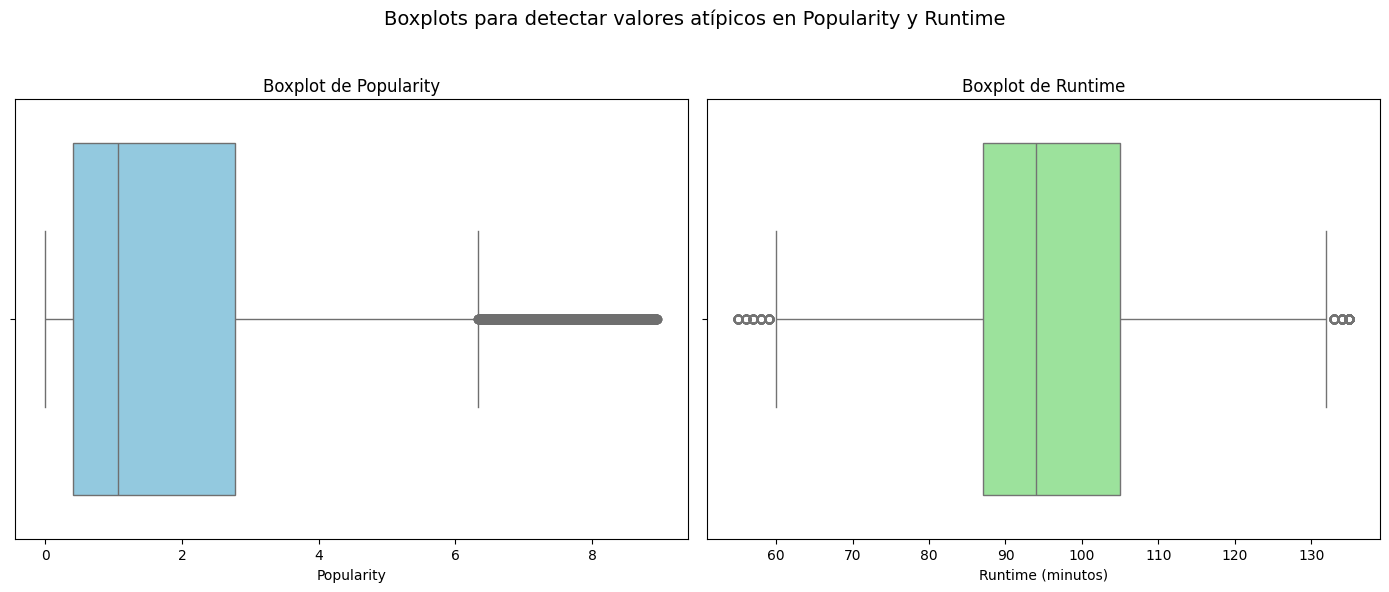

In [80]:
# Configuración de los gráficos
plt.figure(figsize=(14, 6))
plt.suptitle('Boxplots para detectar valores atípicos en Popularity y Runtime', fontsize=14)

# Boxplot para Popularity
plt.subplot(1, 2, 1)
sns.boxplot(data=movies_df, x='popularity', color='skyblue')
plt.title('Boxplot de Popularity')
plt.xlabel('Popularity')

# Boxplot para Runtime
plt.subplot(1, 2, 2)
sns.boxplot(data=movies_df, x='runtime', color='lightgreen')
plt.title('Boxplot de Runtime')
plt.xlabel('Runtime (minutos)')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

Después de eliminar los outliers, generé nuevamente los boxplots de 'Popularity' y 'Runtime'. En estos gráficos se puede observar una reducción en la presencia de valores extremos, especialmente en la variable de Popularity, donde los puntos fuera del rango principal han disminuido notablemente. Esto sugiere que el ajuste fue exitoso y que los datos ahora reflejan una distribución más representativa, lo cual facilitará el análisis y el modelado posterior.

#### **Visualización con una Nube de Palabras**

Usaré una nube de palabras para visualizar las palabras más comunes en los títulos de las películas. 

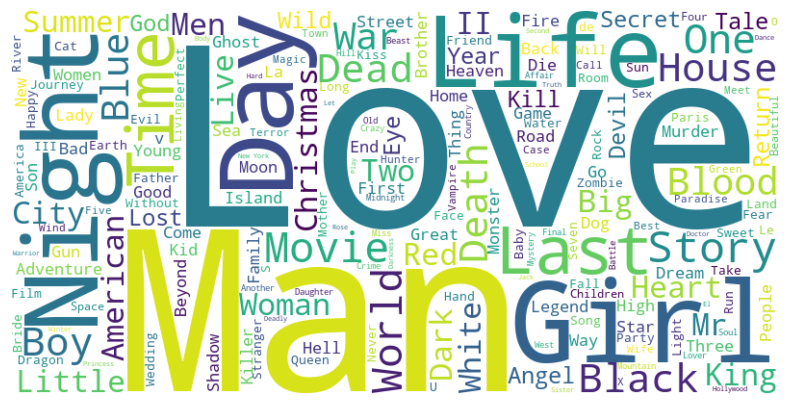

In [81]:
# Concatenar todos los títulos en una sola cadena de texto
text = " ".join(movies_df['title'].values)

# Generar la nube de palabras
from wordcloud import WordCloud
import matplotlib.pyplot as plt

wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis').generate(text)

# Mostrar la nube de palabras
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

Generé una nube de palabras basada en los títulos de las películas, lo que me permite visualizar las palabras más frecuentes en estos títulos. En esta representación gráfica, las palabras como "Man", "Love", "Life", "Last", y "Girl" aparecen en un tamaño mayor, indicando que son comunes en los títulos de las películas. Esto sugiere que los temas de amor, vida, y personajes como el hombre o la mujer son recurrentes, algo que podría ser relevante al construir un sistema de recomendación que considere la popularidad de ciertos temas.

Este análisis inicial proporciona una idea de los conceptos principales y temas frecuentes en los títulos, lo cual es útil para explorar patrones o tendencias en los datos. Esta información podría ayudar a refinar las recomendaciones, ya que temas populares podrían guiar los gustos de los usuarios en el sistema de recomendación.